In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

## 1) Model Definition
- Define our generator -> UNet
- Define our discriminator -> PatchGAN

In [2]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

def define_generator(image_shape=(256,256,3)):
    output_channels = 3

    # base model
    base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False)
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable = True

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    # define the unet
    inputs = tf.keras.layers.Input(shape=image_shape)
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)
    out_image = Activation('tanh')(x)

    return Model(inputs=inputs, outputs=out_image)

In [23]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

## 1) Data Handling
- load_real_samples

In [13]:
# load and prepare training images
def load_real_samples(img_dir, mask_dir, starting_img_shape):
    # validate if the path name is correct
    assert os.path.isdir(img_dir), f"Directory does not exist: {img_dir}"
    assert os.path.isdir(mask_dir), f"Directory does not exist: {mask_dir}"

    # load images and masks
    print(f"Loading images and masks for: {img_dir[img_dir.rindex('/') + 1:]}")
    imgs = []
    masks = []

    # load all paths for mask
    mask_paths = os.listdir(mask_dir)

    # start looping
    for path in os.listdir(img_dir):
    # remove the path if it's a json file
    if path.endswith('.json'):
        _ = os.path.join(img_dir, path)
        os.remove(_)
        continue

    # check if the corresponding mask exist
    if path[:path.rindex('.')] + '_mask.jpg' in mask_paths:
        # read images
        _ = os.path.join(img_dir, path)
        img = plt.imread(_)
        img = cv2.resize(img, starting_img_shape)
        imgs.append(img)
        # read masks
        path = path[:path.rindex('.')] + '_mask.jpg'
        _ = os.path.join(mask_dir, path)
        mask = plt.imread(_)
        mask = cv2.resize(mask, starting_img_shape)
        masks.append(mask)
    else:
        print(f'Missing mask for {path}')

    # change into tensors
    imgs = tf.convert_to_tensor(imgs, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    masks = tf.expand_dims(masks, axis = -1)
    masks = tf.image.grayscale_to_rgb(masks)

    print()

    # scale from [0,255] to [-1,1]
    imgs = (imgs - 127.5) / 127.5
    masks = (masks - 127.5) / 127.5

    return [imgs, masks]

## 2) Training Utilities
- augmentation
- generate_real_samples
- generate_fake_samples
- summarize_performance
- train

In [14]:
# select a batch of random samples, returns images and target
def augmentation(img, mask, image_shape):
    # identify tensor shape
    r, c, ch = image_shape
    num = len(img)
    tensor_shape = (num, r, c, ch)

    # crop img (randomly)
    seeds = tf.random.uniform((1, 2), minval=0, maxval=100, dtype=tf.dtypes.int32, seed=None)
    aug_img = tf.image.stateless_random_crop(img, size=tensor_shape, seed=seeds[0], name=None)
    aug_mask = tf.image.stateless_random_crop(mask, size=tensor_shape, seed=seeds[0], name=None)

    # flip img (by chance)
    seeds = tf.random.uniform((1, 2), minval=0, maxval=100, dtype=tf.dtypes.int32, seed=None)
    aug_img = tf.image.stateless_random_flip_left_right(aug_img, seed=seeds[0])
    aug_mask = tf.image.stateless_random_flip_left_right(aug_mask, seed=seeds[0])

    # brightness
    aug_img = tf.image.random_brightness(aug_img, 0.2)

    # contrast
    aug_img = tf.image.random_contrast(aug_img, 0.5, 2.0)

    # saturation
    aug_img = tf.image.random_saturation(aug_img, 0.80, 1.20) #ori is 0.75-1.25

    # hue
    #aug_img = tf.image.random_hue(aug_img, 0.1)

    return aug_img, aug_mask

def generate_real_samples(dataset, n_samples, image_shape, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    # X1, X2 = trainA[ix], trainB[ix] (this one can use if dataset is numpy array)
    X1 = tf.gather(trainA, indices=ix)
    X2 = tf.gather(trainB, indices=ix)
    X1, X2 = augmentation(X1, X2, image_shape)
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [15]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, image_shape, n_samples=3):
# select a sample of input images
[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, image_shape, 1)
# generate a batch of fake samples
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
# scale all pixels from [-1,1] to [0,1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0
# plot real source images
for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_realA[i])
# plot generated target image
for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
# plot real target image
for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_realB[i])
# save plot to file
filename1 = 'plot_%06d.png' % (step+1)
plt.savefig(filename1)
plt.close()
# save the generator model
filename2 = 'model_%06d.h5' % (step+1)
g_model.save(filename2)
print('>Saved: %s and %s' % (filename1, filename2))

In [16]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, image_shape=(256, 256, 3), n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, image_shape, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance every 5 epochs
        if (i+1) % (bat_per_epo * 5) == 0:
            summarize_performance(i, g_model, dataset, image_shape, n_samples=5)

## 3) Training

In [17]:
# root directory for images and masks
img_root_dir = r'To be Filled'
mask_root_dir = r'To be Filled'

# loaded image shape and actual image shape
loaded_img_shape = (300, 300)
image_shape = (256, 256, 3)

# list to contain imgs/masks tensors loaded from different folder
all_imgs = []
all_masks = []

# getting all imgs/masks
for video_name in os.listdir(mask_root_dir):
    img_dir = os.path.join(img_root_dir, video_name)
    mask_dir = os.path.join(mask_root_dir, video_name)
    imgs, masks = load_real_samples(img_dir, mask_dir, loaded_img_shape)
    all_imgs.append(imgs)
    all_masks.append(masks)

# generate the training dataset
train_dataset = [tf.concat(all_imgs, 0), tf.concat(all_masks, 0)]

# summary
print('Loaded', train_dataset[0].shape, train_dataset[1].shape)
print('\nTarget image size', image_shape)

Loading images and masks for: FAMILY MART_MY NEWS

Loading images and masks for: 99 SPEEDMART_TEALIVE

Loaded (186, 300, 300, 3) (186, 300, 300, 3)

Target image size (256, 256, 3)


In [18]:
def show_images(img):
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


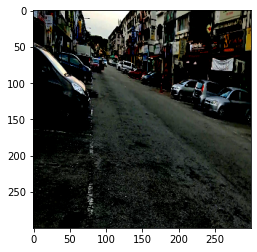

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


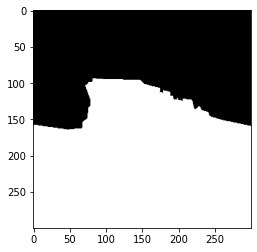

In [19]:
i = 150
show_images(train_dataset[0][i])
show_images(train_dataset[1][i])

In [24]:
# define the models
image_shape = (256, 256, 3)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

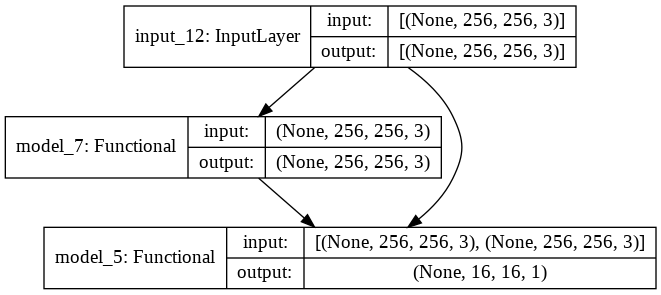

In [25]:
tf.keras.utils.plot_model(
    gan_model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# train model
train(d_model, g_model, gan_model, train_dataset, image_shape)

## 4) Freeze the model and save as pb file

In [39]:
model = tf.keras.models.load_model('/content/model_018600.h5', compile=False)
for layer in model.layers:
    layer.trainable = False

In [ ]:
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

#path of the directory where you want to save your model
frozen_out_path = r'To be Filled'
# name of the .pb file
frozen_graph_filename = 'frozen_graph'
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)